In [2]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

DATA_PATH = "raw-from-source/"

# From the SoS site
DEM_VOTES = 1803362 
REP_VOTES = 1282804
TOTAL_VOTES_CAST = DEM_VOTES + REP_VOTES

### **General Summary**

-------

#### VEST Data

VESTs dataset uses WA's 2018 Election Results and Precinct Boundaries (N rows) for it's shapefile. It only has vote data for the two Senate candidates, Maria Cantwell and Susan Hutchinson. 

VEST data files include:  

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **wa_2018.shp** which has both election results and shapefiles
 
<font color="Coral">They report that "A dozen votes were reported countywide in King County and Yakima County, these were distributed by candidate to precincts based on their share of the precinct-level reported vote." This means that in King County, 11 votes, 10 democratic and 1 republican, were reported from the county elections office and not matched to a precicnt. As such, the 10 democratic votes were split evenly and added  o the 10 precincts that already had the most democratic votes, and likewise the republican vote was added to the percinct with the most republican votes. </font>


The two election data columns reported are:

<font color="DeepSkyBlue">
G18USSDCAN - Maria Cantwell (Democratic Party) 
    
G18USSRHUT - Susan Hutchison (Republican Party)
</font>
 
----------

#### Shapefile data

VEST reportedly collected shapefile data from the [WA Secretary of State](https://www.sos.wa.gov/elections/research/election-results-and-voters-pamphlets.aspx). 

The WA Secretary of State's data files include: 

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **2018Precinct_VERIFIED** which contains shapefiles for precincts and counties that mostly align with the election results data
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **2018Precincts_OK_consol** which contains the same shapefile data at the previous file, with the exception of consolidated districts in Okanogan county which align with the shapefiles the VEST data uses in Okanogan county. However, the election data does not report vote totals for these consolidated districts, and as such, the first file is used to recreate VEST's data
   
-------

#### Election results data

Most election results were pulled from [this statewide election data site](https://results.vote.wa.gov/) or from individual counties, as in the case of King county and Yakima county. 

The WA Secretary of State's data files include: 

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **20181106_allstateprecincts.csv** which contains vote totals matched to precincts within counties
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **20181106_yakimaprecincts.csv** which contains vote totals for Yakima county
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **2018_General_Election_eCanvass.csv** which contains vote totals for King county, data that is not present in 20181106_allstateprecincts.csv
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **2018_Voting_Districts_for_King_County___votdst_area_2018** which contains name conversion data between alphabetical king county precinct names and the number associated with them. Used to incorporate King County data in with the rest of the data files
 
Vote total data by county and precinct was  found on [this page](https://results.vote.wa.gov/results/20181106/export.html) and downloaded directly from [this link](https://results.vote.wa.gov/results/20181106/export/20181106_allcounties.csv), which was found by clicking on the CSV column of the "All Counties" row directly underneatt the "Description" and "County Results" rows on March 8, 2021. 

To find King County precinct-level data, I nagivated to [this data repo](https://data.kingcounty.gov/Voting-Elections/2018-General-Election-eCanvass/ghxg-x8xz) off of King County's official website. 

King County precinct name conversion data was found [here](https://gis-kingcounty.opendata.arcgis.com/datasets/2018-voting-districts-for-king-county-votdst-area-2018/data?geometry=-122.297%2C47.651%2C-121.858%2C47.732).
 
Yakima data was found at this site [this](https://results.vote.wa.gov/results/20181106/yakima/) site. 

-----

All of the data was accessed and downloaded between the dates of March 9th and March 13th, 2021. 


### Loading Shapefile Data

In [3]:
# Shapefile data from WA Secretary of State
master_shape_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precinct_VERIFIED/2018Precincts_VERIFIED.shp")

Columns: Index(['CountyCd', 'PrcCode', 'FullPrc', 'geometry'], dtype='object')
Number of rows: 7336
Number of unique county codes: 39
Number of unique precint codes: 5132
Number of unique FullPrc codes: 7336
--------------------


,CountyCd,PrcCode,FullPrc,geometry
0,AD,111,AD00000111,"POLYGON ((-118.37353 47.13614, -118.37353 47.1..."
1,AD,112,AD00000112,"POLYGON ((-118.37079 47.13292, -118.37098 47.1..."
2,AD,113,AD00000113,"POLYGON ((-118.36870 47.12700, -118.36866 47.1..."
3,AD,114,AD00000114,"POLYGON ((-118.37378 47.12402, -118.37362 47.1..."
4,AD,115,AD00000115,"POLYGON ((-118.37107 47.12031, -118.37097 47.1..."


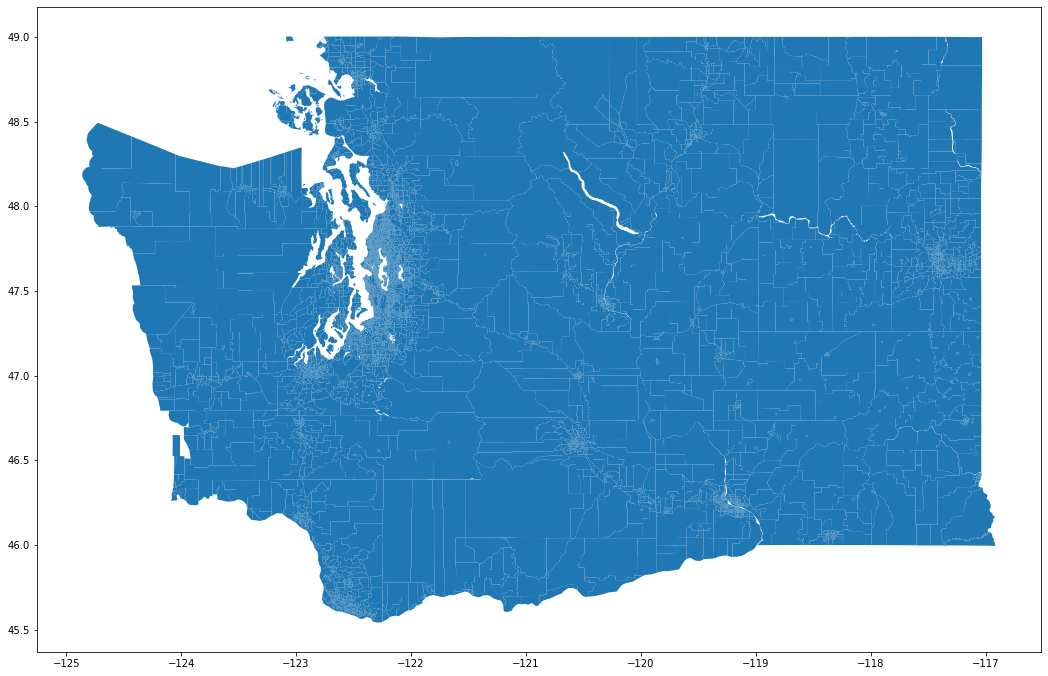

In [4]:
# Copy and briefly analyze the shapefile data

# Notice the "FullPrc" column, is a combo of countycode and precinct code and 
# will serve as a unique ID for a precinct

shape_df = master_shape_df.copy()
shape_df.plot(figsize=(18, 18))

print(f"Columns: {shape_df.keys()}")
print(f"Number of rows: {len(shape_df)}")
print(f"Number of unique county codes: {len(shape_df['CountyCd'].unique())}")
print(f"Number of unique precint codes: {len(shape_df['PrcCode'].unique())}")
print(f"Number of unique FullPrc codes: {len(shape_df['FullPrc'].unique())}")
print('-' * 20)

display(shape_df.head())

### Loading and processing election results data

##### <font color="coral"> About one hundred precints' data is intentionally obfuscated in the raw data, likely for voter protection.</font>

##### <font color="coral"> However, countywide vote totals represent unaltered vote counts.</font>

In [5]:
# Election data
master_election_df = pd.read_csv(DATA_PATH + "direct-download/20181106_allstateprecincts.csv")
display(master_election_df.head())
election_df = master_election_df.copy()

# No precinct-level data reported for KI, otherwise filter out
# the summary "Total" rows
election_df = election_df[election_df["Race"] == "U.S. Senator"]

# We will eliminate countywide-summary data
election_df = election_df[(election_df["PrecinctCode"] != -1) ^ (election_df["CountyCode"] == "KI")]
election_df["PrecinctCode"] = election_df["PrecinctCode"].astype('str')

# There will be a discrepancy of total votes reported and the sum of votes
# reported at the precinct level
election_orig_votes = election_df["Votes"].sum()
print("Total number of votes reported in election data:", election_orig_votes)
print("Expected total votes:", TOTAL_VOTES_CAST)
print(f"That's a difference of {abs(TOTAL_VOTES_CAST - election_df['Votes'].sum())} votes from obfuscation.")

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
0,U.S. Senator,AD,Maria Cantwell,Total,-1,1365
1,U.S. Senator,AD,Susan Hutchison,Total,-1,2867
2,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #1,111,38
3,U.S. Senator,AD,Susan Hutchison,Ritzville Ward #1,111,89
4,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #2,112,36


Total number of votes reported in election data: 3084785
Expected total votes: 3086166
That's a difference of 1381 votes from obfuscation.


### Process election data precinct names to align with those of the shapefile

In [6]:
# Precinct names in county 'FR' need to be of length 3
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "FR", 
                                       election_df["PrecinctCode"].astype('str').str.rjust(3, '0'), 
                                         election_df["PrecinctCode"])

# Precinct names in county 'KP' need to have leading 1s stripped and then 0s stripped
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "KP", 
                                        election_df["PrecinctCode"].astype('str').str.lstrip('1'), 
                                          election_df["PrecinctCode"])
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "KP", 
                                        election_df["PrecinctCode"].astype('str').str.lstrip('0'), 
                                          election_df["PrecinctCode"])

# Precinct names in county 'TH' need to be of len 3 with leading 0s
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "TH", 
                                       election_df["PrecinctCode"].astype('str').str.rjust(3, '0'), 
                                          election_df["PrecinctCode"])

# Precinct name in "GY" need to be length 3
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "GY", 
                                       election_df["PrecinctCode"].astype('str').str.rjust(3, '0'), 
                                          election_df["PrecinctCode"])

# Precinct name in "PI" needs to be of length 5 and have a dash in between the 2nd and 
# 3rd character
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "PI", 
                                       election_df["PrecinctCode"].astype('str').str.rjust(5, '0'), 
                                          election_df["PrecinctCode"])

election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "PI", 
                                       election_df["PrecinctCode"].astype('str').str.slice(0,2) + \
                                               election_df["PrecinctCode"].astype('str').str.slice(2).str.rjust(3, '0'), 
                                                    election_df["PrecinctCode"])


# Make sure we haven't clobbered any vote count data
assert(election_orig_votes == election_df.Votes.sum())

### Special processing of King County, of which the precinct level data values are not included in the election data. 

In [7]:
# We still have the leftover KI summary column in our election_df, should remove it 
election_king = election_df[election_df["CountyCode"] == "KI"]
election_df = election_df[election_df["CountyCode"] != "KI"]

display(election_king)
total_rep = election_king.iloc[1]["Votes"]
total_dem = election_king.iloc[0]["Votes"]

print(f"Expected votes, dem: {total_dem} and rep: {total_rep}")

# Import King County precinct-level data
king_df = pd.read_csv(DATA_PATH + "direct-download/KI_County_18_Genelec.csv")

# Filter out non-Senatorial data, filter out third and minor parties
king_df = king_df[king_df["Race"] == "US Senator"]
king_df = king_df[(king_df["Party"] == "Rep") ^ (king_df["Party"] == "Dem")]

# Converting King County names to their respective codes
alpha2num = pd.read_csv(DATA_PATH + "direct-download/KI_County_Prc_Name_to_ID_num.csv")
alpha2num["votdst"] = alpha2num["votdst"].astype('str').str.rjust(4, '0')
alpha2num = {name : num for name, num in zip(alpha2num["NAME"], alpha2num["votdst"])}

# Elections office does not correspond to any precincts, but apparently was distributed 
# across precincts based on some metric. Table this for now, but we should expect to see
# 11 less votes than our partner's KI data before we distribute them. 
king_df["Precinct"] = king_df["Precinct"].apply(lambda x: alpha2num[x] if x in alpha2num else x)
display(king_df[king_df["Precinct"] == "ELECTIONS OFFICE"])

# Create FullPrc for later joining
king_df["FullPrc"] = "KI" + king_df["Precinct"].str.rjust(8, "0")
king_df = king_df.set_index("FullPrc")

king_df = pd.pivot_table(king_df, index="FullPrc", columns="CounterType", values="SumOfCount", aggfunc="first")
king_df["CountyCode"] = "KI"
king_df.reset_index(level=0, inplace=True)

# Check that the vote counts match between election votes and new King DF votes 
assert(king_df["Maria Cantwell"].sum() == total_dem)
assert(king_df["Susan Hutchison"].sum() == total_rep)

# Distribute ELECTIONS OFFICE votes to top precincts based on number of votes for that candidate
elections_office_results = king_df[king_df["FullPrc"] == "KIELECTIONS OFFICE"]
office_dems = elections_office_results["Maria Cantwell"].iloc[0]
office_reps = elections_office_results["Susan Hutchison"].iloc[0]

dem_votes = king_df["Maria Cantwell"].to_numpy()
rep_votes = king_df["Susan Hutchison"].to_numpy()

# Distribute Dem Votes
dem_idxs = np.argsort(dem_votes)[::-1][:office_dems]
for idx in dem_idxs:
    king_df.iloc[idx, 1] += 1

# Distribute Rep votes
rep_idxs = np.argsort(rep_votes)[::-1][:office_reps]
for idx in rep_idxs:
    king_df.iloc[idx, 2] += 1

# Remove elections office precinct 
king_df = king_df[king_df["FullPrc"] != "KIELECTIONS OFFICE"]
print("Final Version of King Data")
display(king_df.head())

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
2496,U.S. Senator,KI,Maria Cantwell,Total,-1,708654
2497,U.S. Senator,KI,Susan Hutchison,Total,-1,247071


Expected votes, dem: 708654 and rep: 247071


,Precinct,Race,LEG,CC,CG,CounterGroup,Party,CounterType,SumOfCount
364791,ELECTIONS OFFICE,US Senator,0,0,9,Total,Rep,Susan Hutchison,1
364792,ELECTIONS OFFICE,US Senator,0,0,9,Total,Dem,Maria Cantwell,10


Final Version of King Data


CounterType,FullPrc,Maria Cantwell,Susan Hutchison,CountyCode
0,KI00000001,258,58,KI
1,KI00000003,265,111,KI
2,KI00000009,113,64,KI
3,KI00000010,483,258,KI
4,KI00000011,140,56,KI


### Separate processing for Yakima county, similar to King County, which had some missing data in the general election file. 

In [8]:
# Import Yakima precinct-data
yakima_df = pd.read_csv(DATA_PATH + "direct-download/20181106_yakimaprecincts.csv")
display(election_df[election_df["CountyCode"] == "YA"])
election_df = election_df[election_df["CountyCode"] != "YA"]

yakima_df.rename(columns={"U.S. Senator" : "Race", "Maria Cantwell" : "Candidate", \
                            "Total" : "PrecinctName", "-1" : "PrecinctCode", "29476" : "Votes"}, inplace=True)

yakima_df = yakima_df[(yakima_df["Candidate"] == "Maria Cantwell") ^ (yakima_df["Candidate"] == "Susan Hutchison")]

# First rows are summary or courthouse precincts with 0 votes
yakima_df.drop([0, 1, 2], inplace=True)
yakima_df["FullPrc"] = "YA" + yakima_df["PrecinctCode"].astype('str').str.rjust(8,"0")

yakima_df = pd.pivot_table(yakima_df, index="FullPrc", columns="Candidate", values="Votes", aggfunc="first")
yakima_df["CountyCode"] = "YA"
yakima_df.reset_index(level=0, inplace=True)

# Our patners distribute one more dem vote reported at the county courthouse 
# to the precinct with the most dem votes. This dem vote recorded at the county
# courthouse has been obfuscated in the more recently downloaded data

idx_to_increment = np.argsort(yakima_df["Maria Cantwell"].to_numpy())[::-1][0]
yakima_df.iloc[idx_to_increment, 1] += 1

print("Final Version of Yakima County Data")
display(yakima_df.head())

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
9052,U.S. Senator,YA,Maria Cantwell,0001 - COUNTY COURTHOUSE(*),1,0
9053,U.S. Senator,YA,Susan Hutchison,0001 - COUNTY COURTHOUSE(*),1,0
9054,U.S. Senator,YA,Maria Cantwell,0101.333,101,130
9055,U.S. Senator,YA,Susan Hutchison,0101.333,101,102
9056,U.S. Senator,YA,Maria Cantwell,0102.333,102,94
...,...,...,...,...,...,...
9393,U.S. Senator,YA,Susan Hutchison,5020.584,5020,262
9394,U.S. Senator,YA,Maria Cantwell,5101.38,5101,96
9395,U.S. Senator,YA,Susan Hutchison,5101.38,5101,174
9396,U.S. Senator,YA,Maria Cantwell,5202.473(*),5202,0


Final Version of Yakima County Data


Candidate,FullPrc,Maria Cantwell,Susan Hutchison,CountyCode
0,YA00000101,130,102,YA
1,YA00000102,94,44,YA
2,YA00000103,171,80,YA
3,YA00000104,67,18,YA
4,YA00000105,132,68,YA


### Begin process of merging election and shapefile data, put election in similar, pivoted format as King and Yakima county data

In [9]:
election_df["FullPrc"] = election_df["CountyCode"] + election_df["PrecinctCode"].astype('str').str.rjust(8, "0")

pivot_election = pd.pivot_table(election_df, index="FullPrc", \
                                columns=["Candidate"], aggfunc="first", values="Votes")
pivot_election.reset_index(level=0, inplace=True) 
pivot_election["CountyCode"] = pivot_election["FullPrc"].astype('str').str.slice(0, 2)

display(pivot_election.head())

Candidate,FullPrc,Maria Cantwell,Susan Hutchison,CountyCode
0,AD00000111,38,89,AD
1,AD00000112,36,73,AD
2,AD00000113,59,123,AD
3,AD00000114,58,111,AD
4,AD00000115,55,124,AD


### Join election data with King and Yakima county data

In [10]:
# Stack King, Yakima, and the rest of the data together
print(f"Expecting length {len(yakima_df)} + {len(king_df)} + {len(pivot_election)} = {len(yakima_df) + len(king_df) + len(pivot_election)}")
print(f"Does the length of pivot election deviate from the number of unique fullprcs?", len(pivot_election), len(pivot_election["FullPrc"].unique()))

complete_election = pd.concat([pivot_election, yakima_df, king_df])

print(f"Final dimensions: {complete_election.shape}")
print("Complete election total votes:", complete_election["Maria Cantwell"].sum() + complete_election["Susan Hutchison"].sum())
print("Compared to initial election_df votes, should be 1 less due to YA county", election_orig_votes)
print("Compare to total expected votes, should still be ~1380 short:", TOTAL_VOTES_CAST)

display(complete_election.head())

Expecting length 172 + 2603 + 4487 = 7262
Does the length of pivot election deviate from the number of unique fullprcs? 4487 4487
Final dimensions: (7262, 4)
Complete election total votes: 3084786
Compared to initial election_df votes, should be 1 less due to YA county 3084785
Compare to total expected votes, should still be ~1380 short: 3086166


,FullPrc,Maria Cantwell,Susan Hutchison,CountyCode
0,AD00000111,38,89,AD
1,AD00000112,36,73,AD
2,AD00000113,59,123,AD
3,AD00000114,58,111,AD
4,AD00000115,55,124,AD


### Checking for differences in precinct names within each county between election data and shapefile data

In [11]:
# Now look at the difference between the county codes for each county
def compare_county_precinct_names(df1, count_col1, df2, count_col2, prc_code1, 
                                      prc_code2, county, df1_name, df2_name):
    print()
    print(f"County: {county}")
    print('-' * 20)
    
    c1s = df1[df1[count_col1] == county]
    c2s = df2[df2[count_col2] == county]
    
    c1_codes = c1s[prc_code1].sort_values()
    c2_codes = c2s[prc_code2].sort_values()
    
    print(f"{df1_name}, {df2_name} : {len(c1_codes)}, {len(c2_codes)}")
    
    in_df1_not_df2 = c1s[~c1s[prc_code1].isin(c2s[prc_code2])][prc_code1]
    in_df2_not_df1 = c2s[~c2s[prc_code2].isin(c1s[prc_code1])][prc_code2]
    
    if len(c1_codes) != len(c2_codes) or not np.array_equal(c1_codes, c2_codes):
        if len(in_df1_not_df2) > 0:
            print(f"Different number of codes between dataframes for county: {county}")
            print(f"These codes in {df1_name} but not {df2_name}:") 
            display(c1s[~c1s[prc_code1].isin(c2s[prc_code2])][prc_code1])
            print()

            print(f"These codes in {df2_name} but not {df1_name}:") 
            display(c2s[~c2s[prc_code2].isin(c1s[prc_code1])][prc_code2])
            
        

counties = complete_election["CountyCode"].unique()
for county in counties:
    compare_county_precinct_names(complete_election, "CountyCode", shape_df, "CountyCd", "FullPrc", 
                                      "FullPrc", county, "complete_election", "shape_df")


County: AD
--------------------
complete_election, shape_df : 31, 31

County: AS
--------------------
complete_election, shape_df : 26, 26

County: BE
--------------------
complete_election, shape_df : 231, 243

County: CH
--------------------
complete_election, shape_df : 85, 85

County: CM
--------------------
complete_election, shape_df : 67, 67

County: CR
--------------------
complete_election, shape_df : 287, 287

County: CU
--------------------
complete_election, shape_df : 13, 13

County: CZ
--------------------
complete_election, shape_df : 74, 74

County: DG
--------------------
complete_election, shape_df : 47, 47

County: FE
--------------------
complete_election, shape_df : 19, 19

County: FR
--------------------
complete_election, shape_df : 104, 104

County: GA
--------------------
complete_election, shape_df : 12, 12

County: GR
--------------------
complete_election, shape_df : 74, 75

County: GY
--------------------
complete_election, shape_df : 75, 77

County: IS
--

4389    WM00000271
Name: FullPrc, dtype: object


These codes in shape_df but not complete_election:


6837    WM00000000
Name: FullPrc, dtype: object


County: WT
--------------------
complete_election, shape_df : 69, 69

County: YA
--------------------
complete_election, shape_df : 172, 177

County: KI
--------------------
complete_election, shape_df : 2603, 2603


TODO: does the WM have the same shapefile results?

### Merge election and shapefile data

In [12]:
print("shape_df before merge", shape_df.shape)
print("complete before merge", complete_election.shape)

recreated_data = shape_df.merge(complete_election, on="FullPrc", how="right")
recreated_data.head()

recreated_data["CountyCode"] = np.where(recreated_data["CountyCode"] == np.nan,
                                       recreated_data["CountyCd"], 
                                       recreated_data["CountyCode"])

recreated_data["CountyCd"] = np.where(recreated_data["CountyCd"] == np.nan,
                                       recreated_data["CountyCode"], 
                                       recreated_data["CountyCd"])

print("recreated_data shape", recreated_data.shape)
display(recreated_data.head())
print("Recreated data final vote counts vs total reported vote counts, should still be 1381 short:")
print(f"{recreated_data['Maria Cantwell'].dropna().astype('int').sum()} : {DEM_VOTES}, {recreated_data['Susan Hutchison'].dropna().astype('int').sum()} : {REP_VOTES}") 

# print well that's really a bummer, we have extra votes sneaking in somewhere

shape_df before merge (7336, 4)
complete before merge (7262, 4)
recreated_data shape (7262, 7)


,CountyCd,PrcCode,FullPrc,geometry,Maria Cantwell,Susan Hutchison,CountyCode
0,AD,111,AD00000111,"POLYGON ((-118.37353 47.13614, -118.37353 47.1...",38,89,AD
1,AD,112,AD00000112,"POLYGON ((-118.37079 47.13292, -118.37098 47.1...",36,73,AD
2,AD,113,AD00000113,"POLYGON ((-118.36870 47.12700, -118.36866 47.1...",59,123,AD
3,AD,114,AD00000114,"POLYGON ((-118.37378 47.12402, -118.37362 47.1...",58,111,AD
4,AD,115,AD00000115,"POLYGON ((-118.37107 47.12031, -118.37097 47.1...",55,124,AD


Recreated data final vote counts vs total reported vote counts, should still be 1381 short:
1802780 : 1803362, 1282006 : 1282804


### Download VEST data for comparison

In [13]:
# Download the partner_df
master_partner_df = gp.read_file(DATA_PATH + "VEST-wa-data/wa_2018.shp")

<class 'geopandas.geodataframe.GeoDataFrame'>


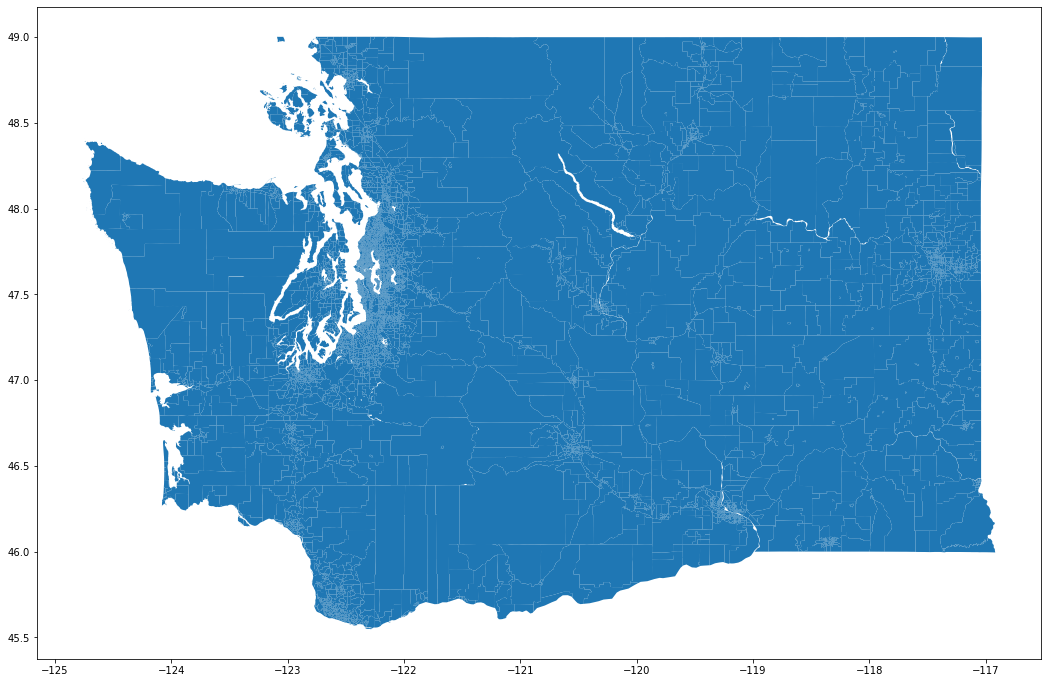

In [14]:
partner_df = master_partner_df.copy()
print(type(partner_df))
partner_df.plot(figsize=(18,18))
partner_df.rename(columns={old : old + "_x" for old in partner_df.keys() if old != "FULLPRC"}, inplace=True)

In [15]:
partner_df.head()

,COUNTYCD_x,PRCCODE_x,FULLPRC,G18USSDCAN_x,G18USSRHUT_x,geometry_x
0,AD,111,AD00000111,38,89,"POLYGON ((-118.37353 47.13614, -118.37353 47.1..."
1,AD,112,AD00000112,36,73,"POLYGON ((-118.37079 47.13292, -118.37098 47.1..."
2,AD,113,AD00000113,59,123,"POLYGON ((-118.36870 47.12700, -118.36866 47.1..."
3,AD,114,AD00000114,58,111,"POLYGON ((-118.37378 47.12402, -118.37362 47.1..."
4,AD,115,AD00000115,55,124,"POLYGON ((-118.37107 47.12031, -118.37097 47.1..."


### Standardize merged shape and election data columns with VEST data columns

In [16]:
recreated_data.rename(columns={"Maria Cantwell" : "G18USSDCAN", "Susan Hutchison" : "G18USSRHUT"}, inplace=True)
recreated_data.rename(columns={old : old.upper() for old in recreated_data.keys() if old != "geometry"}, inplace=True)
recreated_data.rename(columns={old : old + "_y" for old in recreated_data.keys() if old != "FULLPRC"}, inplace=True)

print()
recreated_data.head()

,COUNTYCD_y,PRCCODE_y,FULLPRC,geometry_y,G18USSDCAN_y,G18USSRHUT_y,COUNTYCODE_y
0,AD,111,AD00000111,"POLYGON ((-118.37353 47.13614, -118.37353 47.1...",38,89,AD
1,AD,112,AD00000112,"POLYGON ((-118.37079 47.13292, -118.37098 47.1...",36,73,AD
2,AD,113,AD00000113,"POLYGON ((-118.36870 47.12700, -118.36866 47.1...",59,123,AD
3,AD,114,AD00000114,"POLYGON ((-118.37378 47.12402, -118.37362 47.1...",58,111,AD
4,AD,115,AD00000115,"POLYGON ((-118.37107 47.12031, -118.37097 47.1...",55,124,AD


In [17]:
# We will merge on FullPrcs, let's see how many FullsPrcs are different between recreated
# and VEST data

in_rec_not_partner = recreated_data[~recreated_data["FULLPRC"].isin(partner_df["FULLPRC"])]
in_partner_not_rec = partner_df[~partner_df["FULLPRC"].isin(recreated_data["FULLPRC"])]

print("Number of fullprcs recreated but not in partner:", len(in_rec_not_partner), "out of", len(recreated_data["FULLPRC"]))
print("Number of fullprcs in partner but not recreated:", len(in_partner_not_rec), "out of", len(partner_df["FULLPRC"]))

display(in_rec_not_partner)
display(in_partner_not_rec)

Number of fullprcs recreated but not in partner: 24 out of 7262
Number of fullprcs in partner but not recreated: 74 out of 7312


,COUNTYCD_y,PRCCODE_y,FULLPRC,geometry_y,G18USSDCAN_y,G18USSRHUT_y,COUNTYCODE_y
1712,OK,4,OK00000004,"POLYGON ((-118.83685 48.95986, -118.83683 48.9...",7,15,OK
1717,OK,9,OK00000009,"POLYGON ((-119.05413 48.91751, -119.05426 48.9...",18,41,OK
1725,OK,17,OK00000017,"POLYGON ((-119.55190 48.38314, -119.55312 48.3...",25,33,OK
1733,OK,25,OK00000025,"POLYGON ((-119.71170 48.20768, -119.71117 48.2...",22,92,OK
1737,OK,31,OK00000031,"POLYGON ((-119.60390 48.61248, -119.59033 48.6...",0,0,OK
1739,OK,33,OK00000033,"POLYGON ((-119.46682 48.62612, -119.46594 48.6...",23,88,OK
1740,OK,34,OK00000034,"POLYGON ((-119.00111 48.58300, -119.00092 48.5...",53,70,OK
1747,OK,41,OK00000041,"POLYGON ((-118.83603 48.66819, -118.83621 48.6...",45,118,OK
1756,OK,50,OK00000050,"POLYGON ((-119.59033 48.61236, -119.58197 48.6...",27,79,OK
1761,OK,55,OK00000055,"POLYGON ((-119.03391 48.72382, -119.03414 48.7...",6,20,OK


,COUNTYCD_x,PRCCODE_x,FULLPRC,G18USSDCAN_x,G18USSRHUT_x,geometry_x
68,BE,1291,BE00001291,0,0,"POLYGON ((-119.63928 46.40417, -119.62353 46.4..."
69,BE,1292,BE00001292,0,0,"POLYGON ((-119.87430 46.47642, -119.86441 46.4..."
73,BE,1364,BE00001364,0,0,"POLYGON ((-119.37075 46.07179, -119.37076 46.0..."
80,BE,1407,BE00001407,0,0,"POLYGON ((-119.33748 46.32104, -119.33693 46.3..."
121,BE,2409,BE00002409,0,0,"POLYGON ((-119.61858 46.37505, -119.58059 46.3..."
140,BE,2632,BE00002632,0,0,"POLYGON ((-119.19069 46.17014, -119.18024 46.1..."
152,BE,3003,BE00003003,0,0,"POLYGON ((-119.47406 46.25115, -119.47145 46.2..."
294,BE,6316,BE00006316,0,0,"POLYGON ((-119.35224 46.22573, -119.35307 46.2..."
296,BE,96,BE00000096,0,0,"POLYGON ((-119.78873 46.49076, -119.78906 46.5..."
297,BE,97,BE00000097,0,0,"POLYGON ((-119.42803 46.38269, -119.42803 46.3..."


### Merge and get ready for validation

In [18]:
val_df = partner_df.merge(recreated_data, on="FULLPRC", how="outer")
for col in ["G18USSRHUT", "G18USSDCAN"]:
    val_df[col + "_x"].fillna(0, inplace=True)
    val_df[col + "_y"].fillna(0, inplace=True)
print("Here is what the merged data looks like:")
val_df.head()

Here is what the merged data looks like:


,COUNTYCD_x,PRCCODE_x,FULLPRC,G18USSDCAN_x,G18USSRHUT_x,geometry_x,COUNTYCD_y,PRCCODE_y,geometry_y,G18USSDCAN_y,G18USSRHUT_y,COUNTYCODE_y
0,AD,111,AD00000111,38.0,89.0,"POLYGON ((-118.37353 47.13614, -118.37353 47.1...",AD,111,"POLYGON ((-118.37353 47.13614, -118.37353 47.1...",38.0,89.0,AD
1,AD,112,AD00000112,36.0,73.0,"POLYGON ((-118.37079 47.13292, -118.37098 47.1...",AD,112,"POLYGON ((-118.37079 47.13292, -118.37098 47.1...",36.0,73.0,AD
2,AD,113,AD00000113,59.0,123.0,"POLYGON ((-118.36870 47.12700, -118.36866 47.1...",AD,113,"POLYGON ((-118.36870 47.12700, -118.36866 47.1...",59.0,123.0,AD
3,AD,114,AD00000114,58.0,111.0,"POLYGON ((-118.37378 47.12402, -118.37362 47.1...",AD,114,"POLYGON ((-118.37378 47.12402, -118.37362 47.1...",58.0,111.0,AD
4,AD,115,AD00000115,55.0,124.0,"POLYGON ((-118.37107 47.12031, -118.37097 47.1...",AD,115,"POLYGON ((-118.37107 47.12031, -118.37097 47.1...",55.0,124.0,AD


### First, validate vote counts. 

##### This will be a little complicated due to the obfuscated precincts within the recreated data. VEST contains-non obfuscated data. As such, we will directly verify the precincts for which both VEST and the recreated data have vote counts. For the remaining VEST precincts which we are unable to directly verify, we can assure that the sum of the additional votes present in VEST for each county compared to our recreated data equal the difference between our countywide-reported vote counts and recreated data vote counts. In short, we won't be able to verify all precinct votes, but can verify that VEST data contains an accurate number of votes at the county level. 

In [19]:
# Let's try to verify on a county wide basis 
def validater_row_vect(df, name_column, column_list, verbose=False):
    matching_rows = 0
    different_rows = 0
    
    county_join_cols = (df[name_column]).to_numpy()
    
    # it's because before, we were checking that a row was entirely consistent
    # here, we are double checking a lot
    # so, let's just keep one track of the rows that are messed up
    
    wrong_idxs = np.zeros(len(df))
    for i in column_list:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        #print("Wrong idxs", wrong_idxs)
        
    # we are close, we get the same result, but are double adding lots of rows
    different_rows += np.sum(wrong_idxs)
    matching_rows += len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
    diff_counties = list(set([county[:2] for county in diff_list]))
    
    if int(different_rows) != 0 or verbose:
        print("There are ", len(df.index)," total rows")
        print(f"{int(different_rows)} of these rows have election result differences")
        print(f"{int(matching_rows)} of these rows are the same")
        print(diff_list)
        # print(diff_counties)
        print("")
        
    return (int(different_rows) == 0, diff_list)
    
    
counties = val_df["COUNTYCD_x"].unique()
problem_counties = []
validated_counties = []
county2difflist = {}
for county in counties:
    print("County:", county)
    print('-' * 20)
    local_df = val_df[val_df["COUNTYCD_x"] == county]
    success, problem_prcs = validater_row_vect(local_df, "FULLPRC", ["G18USSDCAN", "G18USSRHUT"])
    county2difflist[county] = problem_prcs
    if success:
        validated_counties.append(county)
    else:
        problem_counties.append(county)

print("Counties that are good", validated_counties)
print("Counties that need work", problem_counties)

County: AD
--------------------
County: AS
--------------------
County: BE
--------------------
There are  243  total rows
16 of these rows have election result differences
227 of these rows are the same
['BE00001020' 'BE00001021' 'BE00001060' 'BE00001061' 'BE00001090'
 'BE00001241' 'BE00001360' 'BE00001362' 'BE00001363' 'BE00001403'
 'BE00001408' 'BE00001413' 'BE00005631' 'BE00005634' 'BE00005636'
 'BE00006311']

County: CH
--------------------
There are  85  total rows
3 of these rows have election result differences
82 of these rows are the same
['CH00001158' 'CH00000136' 'CH00000152']

County: CM
--------------------
County: CR
--------------------
There are  287  total rows
3 of these rows have election result differences
284 of these rows are the same
['CR00000511' 'CR00000513' 'CR00000576']

County: CU
--------------------
County: DG
--------------------
County: FE
--------------------
County: FR
--------------------
There are  104  total rows
3 of these rows have election resul

### Now, attempt to verify the counties with obfuscated precincts

In [20]:
countywide_totals = master_election_df.copy()
countywide_totals = countywide_totals[countywide_totals["Race"] == "U.S. Senator"]
countywide_totals = countywide_totals[countywide_totals["PrecinctCode"] == -1]

def validate_obfuscated_precincts(df, county_totals, county, problem_prcs, verbose=False):
    print(f"Validating {county} Vote Counts")
    print("-" * 20)
    
    # County-wide reported totals
    county_d = county_totals[county_totals["Candidate"] == "Maria Cantwell"]["Votes"].iloc[0]
    county_r = county_totals[county_totals["Candidate"] == "Susan Hutchison"]["Votes"].iloc[0]
    
    # County-wide totals from VEST
    partner_d = df[df["COUNTYCD_x"] == county]["G18USSDCAN_x"].sum()
    partner_r = df[df["COUNTYCD_x"] == county]["G18USSRHUT_x"].sum()
    
    # Election votes, not include obfuscated precinct votes, in some 
    # cases will be less than county 
    election_d = df[df["COUNTYCD_x"] == county]["G18USSDCAN_y"].sum()
    election_r = df[df["COUNTYCD_x"] == county]["G18USSRHUT_y"].sum()
    
    problem_d = df[df["FULLPRC"].isin(problem_prcs)]["G18USSDCAN_x"].sum()
    problem_r = df[df["FULLPRC"].isin(problem_prcs)]["G18USSRHUT_x"].sum()
    
    problem_d -= df[df["FULLPRC"].isin(problem_prcs)]["G18USSDCAN_y"].sum()
    problem_r -= df[df["FULLPRC"].isin(problem_prcs)]["G18USSRHUT_y"].sum()
    
    if verbose:
        print(f"Countywide dem and rep: {county_d}, {county_r}")
        print(f"Partner dem and rep: {partner_d}, {partner_r}")
        print(f"Election dem and rep: {election_d}, {election_r}")
        print()
        print(f"Totals of problem prcs, dem and rep: {problem_d}, {problem_r}")
        print(f"Expected totals, dem and rep: {county_d - election_d}, {county_r - election_r}")
        print()
        
    # First check that reported totals match partner data
    #print(f"County and partner dem: {county_d}, {partner_d}")
    assert(partner_d == county_d and partner_r == county_r)
    
    # Check that difference between election results and countywide 
    # totals are completely covered by the precinct votes that differ
    # between partner and recreated data
    assert(problem_r == (county_r - election_r))
    assert(problem_d == (county_d - election_d))
    print()
    
obfuscated_but_correct = []
for county in problem_counties:
    county_totals = countywide_totals[countywide_totals["CountyCode"] == county]
    try: 
        validate_obfuscated_precincts(val_df, county_totals, county, county2difflist[county])
    except AssertionError:
        continue
    # If no assertion errors, mark county as validated
    obfuscated_but_correct.append(county)
    
updated_validated_counties = list(set(validated_counties).union(set(obfuscated_but_correct)))
still_need_work = list(set(problem_counties).difference(set(obfuscated_but_correct)))

print("These counties' vote totals are validated:", updated_validated_counties)
print("These counties still need work:", still_need_work)
    

Validating BE Vote Counts
--------------------

Validating CH Vote Counts
--------------------

Validating CR Vote Counts
--------------------

Validating FR Vote Counts
--------------------

Validating GA Vote Counts
--------------------

Validating GY Vote Counts
--------------------

Validating LE Vote Counts
--------------------

Validating OK Vote Counts
--------------------

Validating PI Vote Counts
--------------------

Validating SK Vote Counts
--------------------

Validating SN Vote Counts
--------------------

Validating TH Vote Counts
--------------------

Validating WL Vote Counts
--------------------

Validating WM Vote Counts
--------------------

Validating WT Vote Counts
--------------------

Validating YA Vote Counts
--------------------

Validating CZ Vote Counts
--------------------

These counties' vote totals are validated: [nan, 'SN', 'WT', 'YA', 'SK', 'TH', 'FE', 'KI', 'PA', 'KS', 'SJ', 'CZ', 'WM', 'AS', 'CH', 'LI', 'KT', 'GY', 'OK', 'JE', 'IS', 'SM', 'PE', 'DG

In [21]:
for county in still_need_work:
    print("County", county)
    print("-" * 20)
    local_df = val_df[val_df["COUNTYCD_x"] == county]
    local_df = local_df[local_df["FULLPRC"].isin(county2difflist[county])]
    display(local_df)
    
for county in still_need_work:
    county_totals = countywide_totals[countywide_totals["CountyCode"] == county]
    try: 
        validate_obfuscated_precincts(val_df, county_totals, county, 
                                      county2difflist[county], verbose=True)
    except AssertionError:
        continue
        

### Thus, we have verified that VEST's vote counts for most precincts and all counties are accurate, and can verify that VEST's assignment of the obfuscated vote total for each county is also accurate. Their election data has been recreated and validated. 

-----
### Now, we attempt to do the same for the shapefiles. 

In [22]:
# Now let's validate some shapefiles
def validate_county_geoms(df, county, crs=3857, verbose=False):
    print(f"County {county}")
    print('-' * 20)
    
    county_df = df[df["COUNTYCD_x"] == county]
    partner_geom = gp.GeoSeries(county_df["geometry_x"])
    recreated_geom = gp.GeoSeries(county_df["geometry_y"])
    
    partner_geom = partner_geom.to_crs(crs)
    recreated_geom = recreated_geom.to_crs(crs)
    
    equal_geoms = partner_geom.geom_almost_equals(recreated_geom, decimal=2)
    print(f"Number of geometries that match: {len(equal_geoms[equal_geoms])} out of {len(partner_geom)}\n")
    # we want to return the shapefiles that are different, and get a since of area
    non_matching_partner = partner_geom[~equal_geoms]
    non_matching_recreated = recreated_geom[~equal_geoms]
    
    p_area = non_matching_partner.area.sum() / 1e6
    r_area = non_matching_recreated.area.sum() / 1e6
    diff_over_county_size = abs(p_area - r_area) / \
        (gp.GeoSeries(county_df["geometry_x"]).to_crs(crs).area.sum() / 1e6)
    
    if verbose:
        display(non_matching_partner)
        display(non_matching_recreated)
        print(f"Partner total area: {p_area} km^2")
        print(f"Recreated total area: {r_area} km^2")
        print(f"Difference of {diff_over_county_size}")
        
    
        
    return (len(equal_geoms[equal_geoms]) == len(partner_geom), 
                non_matching_partner, 
                    non_matching_recreated, round(p_area, 2), round(r_area, 2), 
                        round(diff_over_county_size,2))
    

### Begin validating shapefiles on a county-wide level, reporting counties that demonstrate discrepancies

In [23]:
shapefile_validated = []
shapefile_not_validated = []
counties = val_df["COUNTYCD_x"].unique()
county2leftright = {}

for county in counties:
    success, left, right,l_area, r_area, diff = validate_county_geoms(val_df, county)
    county2leftright[county] = (left, right, l_area, r_area, diff)
    if success:
        shapefile_validated.append(county)
    else:
        shapefile_not_validated.append(county)

County AD
--------------------
Number of geometries that match: 31 out of 31

County AS
--------------------
Number of geometries that match: 26 out of 26

County BE
--------------------
Number of geometries that match: 231 out of 243

County CH
--------------------
Number of geometries that match: 85 out of 85

County CM
--------------------
Number of geometries that match: 39 out of 67

County CR
--------------------
Number of geometries that match: 268 out of 287

County CU
--------------------
Number of geometries that match: 13 out of 13

County DG
--------------------
Number of geometries that match: 47 out of 47

County FE
--------------------
Number of geometries that match: 19 out of 19

County FR
--------------------
Number of geometries that match: 104 out of 104

County GA
--------------------
Number of geometries that match: 12 out of 12

County GR
--------------------
Number of geometries that match: 74 out of 75

County GY
--------------------
Number of geometries that m

<ipython-input-22-a777246e1d63>:21: RuntimeWarning: invalid value encountered in double_scalars
  diff_over_county_size = abs(p_area - r_area) / \


### Plot the shapefile difference between the counties with reported discrepancies to investigate what might be going on. 

In [ ]:
# To make drawing the state much quicker, will use
# pickle and io to continuously store and load 
# matplotlib Figure object to plot with each county's
# differences.  
import pickle as pkl
import io
from tqdm import tqdm

buf = io.BytesIO()
fig, ax = plt.subplots(3, 2, figsize=(10, 12))
ax = ax.flatten()
print("Generating statewide map")
master_partner_df.to_crs(3857).plot(ax=ax[0], color="bisque")
master_shape_df.to_crs(3857).plot(ax=ax[1], color="lightcyan")
print("Finished generating, loaded to buffer")

pkl.dump(fig, buf)
buf.seek(0)

for county in tqdm(shapefile_not_validated):
    print("County", county)
    print('-' * 20)
    
    left, right, l_area, r_area, diff = county2leftright[county]
    fig = pkl.load(buf)
    buf = io.BytesIO()
    pkl.dump(fig, buf)
    buf.seek(0)
    ax = [ax for ax in fig.axes]
    
    ax[0].set_title("VEST shapefile data")
    ax[1].set_title("SoS shapefile data")
    left.plot(ax=ax[0], color="darkorange")
    right.plot(ax=ax[1], color="deepskyblue")
    
    master_partner_df[master_partner_df["COUNTYCD"] == county].to_crs(3857).plot(ax=ax[2], color="bisque")
    master_shape_df[master_shape_df["CountyCd"] == county].to_crs(3857).plot(ax=ax[3],color="lightcyan")
    
    left.plot(ax=ax[2], color="darkorange")
    right.plot(ax=ax[3], color="deepskyblue")
    
    ax[4].set_title("VEST (orange) and SoS (blue)")
    right.plot(ax=ax[4], color="deepskyblue")
    left.plot(ax=ax[4], color="darkorange")
    
    ax[5].text(.1, .8, f"Area of partner precincts: {l_area} km^2")
    ax[5].text(.1, .6, f"Area of recreated precincts: {r_area} km^2")
    ax[5].text(.1, .4, f"Difference : {abs(r_area - l_area)} km^2")
    ax[5].text(.1, .2, f"% of county: {round(diff * 100, 1)}")
    
    for a in ax:
        a.set_yticks([])
        a.set_xticks([])

    fig.suptitle(f"County {county}")
    fig.savefig(f"shapefile_diff/{county}_316")

Generating statewide map
Finished generating, loaded to buffer


  0%|          | 0/22 [00:00<?, ?it/s]

County BE
--------------------


  5%|▍         | 1/22 [00:08<02:53,  8.26s/it]

County CM
--------------------


  9%|▉         | 2/22 [00:15<02:39,  7.97s/it]

County CR
--------------------


 14%|█▎        | 3/22 [00:22<02:24,  7.58s/it]

County GR
--------------------


 18%|█▊        | 4/22 [00:28<02:06,  7.05s/it]

County GY
--------------------


 23%|██▎       | 5/22 [00:33<01:51,  6.53s/it]

County KI
--------------------


 27%|██▋       | 6/22 [00:49<02:29,  9.32s/it]

County LE
--------------------


### Based on visual inspections of counties displayed in the last cell, the majority report shapefile changes between VEST and SoS precincts due to VEST trimmming coastlines and accurately mapping waterways. The following counties' shapefile differences are due to this improved drawing of waterways:

### CM, CR, CZ, GY, JE, KI, KP, MA, PA, PI, SK, SM, TH, WK, WM

In [ ]:
water_cleared_counties = ["CM", "CR", "CZ", "GY", "JE", "KI", "KP", 
                              "MA", "PA", "PI", "SK", "SM", "TH", "WK", "WM"]
shapefile_not_validated = list(set(shapefile_not_validated).difference(set(water_cleared_counties)))

### Take a closer look at the counties whose shapefile differences between VEST and the recreated data still cannot be explaind

In [ ]:
print(shapefile_not_validated)

In [ ]:
def compare_county_maps(df, county):
    partner_county = df[df["COUNTYCD_x"] == county]
    sos_county = df[df["COUNTYCD_y"] == county]
    
    # we want to get FULLPRCS from both, see if there are discrepancies
    partner_prc = partner_county["FULLPRC"]
    sos_prc = sos_county["FULLPRC"]
    
    in_part_not_sos = partner_prc[~partner_prc.isin(sos_prc)].to_list()
    print(f"These precinct names in partner but not SoS: {in_part_not_sos}")
    
    in_sos_not_part = sos_prc[~sos_prc.isin(partner_prc)].to_list()
    print(f"These precinct names in SoS but not partner: {in_sos_not_part}")

In [ ]:
# SN
compare_county_maps(val_df, "SN")
SN_mis = ['SN13918904', 'SN13918914', 'SN13958904', 'SN13958908', 'SN13958909', 
                       'SN13958916', 'SN14428913', 'SN21018906', 'SN21018915', 'SN22128901', 
                       'SN23828903', 'SN23918902', 'SN23918906', 'SN23918907', 'SN23918911', 
                       'SN72138905', 'SN73238910', 'SN732389']
display(val_df[val_df["FULLPRC"].isin(SN_mis)])

In [ ]:
# GR
compare_county_maps(val_df, "GR")
display(val_df[val_df["FULLPRC"] == 'GR00000000'])

In [ ]:
# WL
compare_county_maps(val_df, "WL")
display(val_df[val_df["FULLPRC"] == 'WL00000030'])

In [ ]:
# BE
compare_county_maps(val_df, "BE")
BE_mis = ['BE00001291', 'BE00001292', 'BE00001364', 'BE00001407', 'BE00002409', 
          'BE00002632', 'BE00003003', 'BE00006316', 'BE00000096', 'BE00000097', 
          'BE00000098', 'BE00000099']
display(val_df[val_df["FULLPRC"].isin(BE_mis)])

In [ ]:
# LE
compare_county_maps(val_df, "LE")
LE_mis = ['LE00000020', 'LE00000027', 'LE00000504', 'LE00000505', 'LE00000506']
display(val_df[val_df["FULLPRC"].isin(LE_mis)])

In [ ]:
# YA
compare_county_maps(val_df, "YA")
YA_mis = ['YA00000160', 'YA00002100', 'YA00000300', 'YA00003503', 'YA00000900']
display(val_df[val_df["FULLPRC"].isin(YA_mis)])

### Validating OK county takes a bit of extra work, for the following reasons. 
    1) The SoS provides 2 shapefiles, one with precincts that generally match the precincts reported in the general election results file, and another with "consolidated" precinct files for OK county
    2) VEST uses the consolidated OK shapefiles in their final report
    3) The OK general election results have at least one obfuscated precinct
    
#### As such, we will validate OK county independently. We have already verified that VEST's assigned votes in OK county agree with the number that should be assigned based on countywide reporting. Now, we will check specific merged precinct totals by combining election results with the OK_consol and VEST shapefiles. These assignments were done manually, using a map of OK county's precincts, found at [this site](https://caltopo.com/m/69D3).

In [ ]:
# Second shapefile from SoS
master_ok_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precincts_OK_Consol/2018Precincts_OK_Consol.shp")

In [ ]:
e_df = master_election_df.copy()
ok_df = master_ok_df.copy()
v_df = master_partner_df.copy()

e_df = e_df[e_df["CountyCode"] == "OK"]
ok_df = ok_df[(ok_df["CountyCd"] == "OK") ^ (ok_df["CountyCd"] == "OKC")]
ok_df["FULLPRC"] = ok_df["FullPrc"]
v_df = v_df[(v_df["COUNTYCD"] == "OK") ^ (v_df["COUNTYCD"] == "OKC")]

ok_dem = e_df.iloc[0]["Votes"]
ok_rep = e_df.iloc[1]["Votes"]

e_df = e_df[e_df["PrecinctCode"] != -1]
e_df = e_df[e_df["Race"] == "U.S. Senator"]
e_df = pd.pivot_table(e_df, index = "PrecinctCode", columns="Candidate", values="Votes", aggfunc="first")
e_df.reset_index(inplace=True)

e_df["FULLPRC"] = "OK" + e_df["PrecinctCode"].astype('str').str.rjust(8, "0")

display(e_df.head())
display(ok_df.head())
display(v_df.head())

#### First, confirm that VEST precinct shapefiles match those of OK_consol:

In [ ]:
assert(v_df.geom_almost_equals(ok_df, align=False).all())

#### Next, confirm total vote counts match the reported election_data:

In [ ]:
assert(v_df["G18USSDCAN"].astype('int').sum() == ok_dem)
assert(v_df["G18USSRHUT"].astype('int').sum() == ok_rep)

#### Finally, verify that the majority of assignments are correct, bearing in mind that obfuscated election results will result in some counts not perfectly matching up:

In [86]:
# First, let's see which precincts don't align
display(e_df[~e_df["FULLPRC"].isin(v_df["FULLPRC"])])
display(v_df[~v_df["FULLPRC"].isin(e_df["FULLPRC"])])

Candidate,PrecinctCode,Maria Cantwell,Susan Hutchison,FULLPRC
3,4,7,15,OK00000004
8,9,18,41,OK00000009
16,17,25,33,OK00000017
24,25,22,92,OK00000025
28,31,0,0,OK00000031
30,33,23,88,OK00000033
31,34,53,70,OK00000034
38,41,45,118,OK00000041
47,50,27,79,OK00000050
52,55,6,20,OK00000055


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3759,OK,17C,OKC0000017,25,33,"POLYGON ((-119.56307 48.37627, -119.56358 48.3..."
3769,OK,179C,OKC0000179,28,35,"POLYGON ((-119.71114 48.11651, -119.71134 48.1..."
3778,OK,187C,OKC0000187,20,32,"POLYGON ((-119.50590 48.41110, -119.50560 48.4..."
3794,OK,200C,OKC0000200,23,59,"POLYGON ((-119.61099 48.36451, -119.61013 48.3..."
3820,OK,225C,OKC0000225,12,23,"POLYGON ((-119.54709 48.39228, -119.54731 48.3..."
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3829,OK,25C,OKC0000025,22,92,"POLYGON ((-119.64430 48.26633, -119.62243 48.2..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."


In [115]:
# Rename precincts that were only combined with precincts that had no reported votes:
simple_rename = {
    "OK00000017" : "OKC0000017",
    "OK00000179" : "OKC0000179",
    "OK00000187" : "OKC0000187",
    "OK00000200" : "OKC0000200",
    "OK00000225" : "OKC0000225",
    "OK00000200" : "OKC0000200",
    "OK00000025" : "OKC0000025",
    "OK00000212" : "OKC0000073",
 }
rename = lambda x: simple_rename[x] if x in simple_rename else x
e_df["FULLPRC"] = e_df["FULLPRC"].astype('str').apply(rename)

display(e_df[~e_df["FULLPRC"].isin(v_df["FULLPRC"])])
display(v_df[~v_df["FULLPRC"].isin(e_df["FULLPRC"])])

,FULLPRC,Maria Cantwell,Susan Hutchison
26,OK00000031,0,0
28,OK00000033,23,88
43,OK00000050,27,79
61,OK00000069,24,41
62,OK00000070,16,44
78,OK00000089,13,31
126,OK00000139,14,57
138,OK00000151,20,59


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
3835,OK,301,OK00000301,0,0,"POLYGON ((-119.60661 48.35410, -119.60840 48.3..."
3836,OK,303,OK00000303,0,0,"POLYGON ((-119.47893 48.44322, -119.47893 48.4..."
3837,OK,304,OK00000304,0,0,"POLYGON ((-119.55797 48.38827, -119.55706 48.3..."
3838,OK,305,OK00000305,0,0,"POLYGON ((-119.52303 48.45317, -119.52298 48.4..."
3839,OK,306,OK00000306,0,0,"POLYGON ((-119.52536 48.41874, -119.52550 48.4..."
3840,OK,307,OK00000307,0,0,"POLYGON ((-120.09562 48.35223, -120.09542 48.3..."


In [120]:
# Combine all precincts that make up OK 4C
prcs_in_4 = ["OK00000009", "OK00000096", "OK00000004", "OK00000055", "OK00000041", 
                 "OK00000100", "OK00000034", "OK00000074"]

prcs_in_4 = {old : "OKC0000004" for old in prcs_in_4}
rename = lambda x: prcs_in_4[x] if x in prcs_in_4 else x
e_df["FULLPRC"] = e_df["FULLPRC"].astype('str').apply(rename)

agg_funcs = {"FULLPRC" : "first", "Maria Cantwell" : "sum", "Susan Hutchison": "sum"}
e_df = e_df.groupby("FULLPRC").aggregate(agg_funcs)
e_df.index = [i for i in range(len(e_df))]

#e_df.reset_index(inplace=True)

display(e_df[~e_df["FULLPRC"].isin(v_df["FULLPRC"])])
display(v_df[~v_df["FULLPRC"].isin(e_df["FULLPRC"])])

print(e_df[~e_df["FULLPRC"].isin(v_df["FULLPRC"])]["Maria Cantwell"].astype('int').sum(), 
          e_df[~e_df["FULLPRC"].isin(v_df["FULLPRC"])]["Susan Hutchison"].astype('int').sum())

print(v_df[~v_df["FULLPRC"].isin(e_df["FULLPRC"])]["G18USSDCAN"].astype('int').sum(), 
          v_df[~v_df["FULLPRC"].isin(e_df["FULLPRC"])]["G18USSRHUT"].astype('int').sum())

,FULLPRC,Maria Cantwell,Susan Hutchison
24,OK00000031,0,0
26,OK00000033,23,88
41,OK00000050,27,79
59,OK00000069,24,41
60,OK00000070,16,44
76,OK00000089,13,31
124,OK00000139,14,57
136,OK00000151,20,59


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry
3822,OK,229,OK00000229,0,0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7..."
3824,OK,231,OK00000231,0,0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4..."
3825,OK,234,OK00000234,0,0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4..."
3831,OK,28C,OKC0000028,38,98,"POLYGON ((-119.51690 49.00010, -119.49554 48.9..."
3835,OK,301,OK00000301,0,0,"POLYGON ((-119.60661 48.35410, -119.60840 48.3..."
3836,OK,303,OK00000303,0,0,"POLYGON ((-119.47893 48.44322, -119.47893 48.4..."
3837,OK,304,OK00000304,0,0,"POLYGON ((-119.55797 48.38827, -119.55706 48.3..."
3838,OK,305,OK00000305,0,0,"POLYGON ((-119.52303 48.45317, -119.52298 48.4..."
3839,OK,306,OK00000306,0,0,"POLYGON ((-119.52536 48.41874, -119.52550 48.4..."
3840,OK,307,OK00000307,0,0,"POLYGON ((-120.09562 48.35223, -120.09542 48.3..."


137 399
138 438


### At this point, there are a few potential combinations of precincts from the election data that would reach the vote count reported in the VEST data, with 1 obfuscated Dem vote and 39 obfuscated Rep votes making up the difference. 

In [124]:
# Let's see if there are any other obfuscated counties that could make the totals match a bit better
recreated_df = ok_df.merge(e_df, on="FULLPRC", how="outer")
recreated_df = v_df.merge(recreated_df, on="FULLPRC", how="outer")
recreated_df.head()

,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry_x,CountyCd,PrcCode,FullPrc,geometry_y,Maria Cantwell,Susan Hutchison
0,OK,1,OK00000001,16.0,45.0,"POLYGON ((-119.60900 48.32471, -119.61077 48.3...",OK,1,OK00000001,"POLYGON ((-119.60900 48.32471, -119.61077 48.3...",16.0,45.0
1,OK,10,OK00000010,8.0,37.0,"POLYGON ((-119.90152 48.69690, -119.89953 48.6...",OK,10,OK00000010,"POLYGON ((-119.90152 48.69690, -119.89953 48.6...",8.0,37.0
2,OK,101,OK00000101,62.0,46.0,"POLYGON ((-118.97403 47.96683, -118.97445 47.9...",OK,101,OK00000101,"POLYGON ((-118.97403 47.96683, -118.97445 47.9...",62.0,46.0
3,OK,102,OK00000102,63.0,31.0,"POLYGON ((-118.96243 47.97714, -118.96243 47.9...",OK,102,OK00000102,"POLYGON ((-118.96243 47.97714, -118.96243 47.9...",63.0,31.0
4,OK,103,OK00000103,25.0,25.0,"POLYGON ((-118.96983 47.97154, -118.96987 47.9...",OK,103,OK00000103,"POLYGON ((-118.96983 47.97154, -118.96987 47.9...",25.0,25.0


In [126]:
print("The only mismatched precincts should be those from before:")
display(recreated_df.iloc[np.where((recreated_df["G18USSDCAN"] != recreated_df["Maria Cantwell"]) & (recreated_df["G18USSRHUT"] != recreated_df["Susan Hutchison"]))])


The only mismatched precincts should be those from before:


,COUNTYCD,PRCCODE,FULLPRC,G18USSDCAN,G18USSRHUT,geometry_x,CountyCd,PrcCode,FullPrc,geometry_y,Maria Cantwell,Susan Hutchison
138,OK,229,OK00000229,0.0,0.0,"POLYGON ((-119.46519 48.72690, -119.46429 48.7...",OK,229,OK00000229,"POLYGON ((-119.46519 48.72690, -119.46429 48.7...",NaN,NaN
140,OK,231,OK00000231,0.0,0.0,"POLYGON ((-119.51227 48.41859, -119.51227 48.4...",OK,231,OK00000231,"POLYGON ((-119.51227 48.41859, -119.51227 48.4...",NaN,NaN
141,OK,234,OK00000234,0.0,0.0,"POLYGON ((-120.17638 48.46812, -120.17639 48.4...",OK,234,OK00000234,"POLYGON ((-120.17638 48.46812, -120.17639 48.4...",NaN,NaN
147,OK,28C,OKC0000028,38.0,98.0,"POLYGON ((-119.51690 49.00010, -119.49554 48.9...",OK,28C,OKC0000028,"POLYGON ((-119.51690 49.00010, -119.49554 48.9...",NaN,NaN
150,OK,30,OK00000030,29.0,58.0,"POLYGON ((-119.88376 48.13816, -119.88367 48.1...",OK,30,OK00000030,"POLYGON ((-119.88376 48.13816, -119.88367 48.1...",0.0,0.0
151,OK,301,OK00000301,0.0,0.0,"POLYGON ((-119.60661 48.35410, -119.60840 48.3...",OK,301,OK00000301,"POLYGON ((-119.60661 48.35410, -119.60840 48.3...",NaN,NaN
152,OK,303,OK00000303,0.0,0.0,"POLYGON ((-119.47893 48.44322, -119.47893 48.4...",OK,303,OK00000303,"POLYGON ((-119.47893 48.44322, -119.47893 48.4...",NaN,NaN
153,OK,304,OK00000304,0.0,0.0,"POLYGON ((-119.55797 48.38827, -119.55706 48.3...",OK,304,OK00000304,"POLYGON ((-119.55797 48.38827, -119.55706 48.3...",NaN,NaN
154,OK,305,OK00000305,0.0,0.0,"POLYGON ((-119.52303 48.45317, -119.52298 48.4...",OK,305,OK00000305,"POLYGON ((-119.52303 48.45317, -119.52298 48.4...",NaN,NaN
155,OK,306,OK00000306,0.0,0.0,"POLYGON ((-119.52536 48.41874, -119.52550 48.4...",OK,306,OK00000306,"POLYGON ((-119.52536 48.41874, -119.52550 48.4...",NaN,NaN
